In [105]:
from dotenv import load_dotenv

_ = load_dotenv()

In [106]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage

from langchain_openai import ChatOpenAI
from langchain_core.prompts import (
    PromptTemplate,
    ChatPromptTemplate,
)
from langchain_core.output_parsers import StrOutputParser

import prompts

In [108]:
SYSTEM, HUMAN, AI = "system", "human", "ai"

# Build Graph

In [107]:
class AgentState(TypedDict):
    source_lang: str
    target_lang: str
    original_text: AnyMessage
    translated_text_list: Annotated[list[AnyMessage], operator.add]

In [109]:
llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)

## Specify nodes

In [110]:
# Translate node
TRANSLATE_PROMPT = """Translate the follow text from {source_lang} to {target_lang}:"""
HUMAN_PROMPT = "{source_text}"


def translate_node(state: AgentState):
    chat_template = ChatPromptTemplate.from_messages(
        [(SYSTEM, TRANSLATE_PROMPT), (HUMAN, HUMAN_PROMPT)]
    )

    chain = chat_template | llm | StrOutputParser()
    response = chain.invoke(
        {
            "source_lang": state["source_lang"],
            "target_lang": state["target_lang"],
            "source_text": state["original_text"],
        }
    )
    return {"translated_text_list": [response]}

In [111]:
# Reflection node
def reflection_node(state: AgentState):
    template = PromptTemplate.from_template(prompts.REFLECTION_PROMPT)
    chain = template | llm | StrOutputParser()
    response = chain.invoke(
        {
            "source_lang": state["source_lang"],
            "target_lang": state["target_lang"],
            "source_text": state["original_text"],
            "translation_1": state["translated_text_list"][-1],
        }
    )
    return {"translated_text_list": state["translated_text_list"] + [response]}

In [112]:
# Final translation node
def improve_translate_node(state: AgentState):
    template = PromptTemplate.from_template(prompts.IMPROVEMENT_PROMPT)
    chain = template | llm | StrOutputParser()
    response = chain.invoke(
        {
            "source_lang": state["source_lang"],
            "target_lang": state["target_lang"],
            "source_text": state["original_text"],
            "translation_1": state["translated_text_list"][-2],
            "reflection": state["translated_text_list"][-1],
        }
    )
    return {"translated_text_list": state["translated_text_list"] + [response]}

## Specify graph

In [113]:
builder = StateGraph(AgentState)
builder.add_node("translate", translate_node)
builder.add_node("reflection", reflection_node)
builder.add_node("improve_translate", improve_translate_node)
builder.add_edge("translate", "reflection")
builder.add_edge("reflection", "improve_translate")
builder.set_entry_point("translate")
builder.add_edge("improve_translate", END)

graph = builder.compile()

## Visualize graph

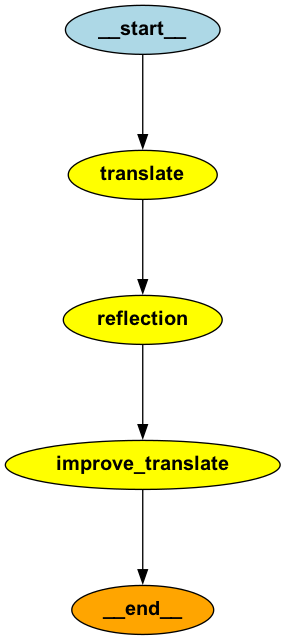

In [114]:
from IPython.display import Image

Image(graph.get_graph().draw_png())

## Run

In [103]:
relative_path = "sample-texts/sample-short1.txt"

with open(relative_path, encoding="utf-8") as file:
    source_text = file.read()
print(source_text)

Last week, I spoke about AI and regulation at the U.S. Capitol at an event that was attended by legislative and business leaders. I’m encouraged by the progress the open source community has made fending off regulations that would have stifled innovation. But opponents of open source are continuing to shift their arguments, with the latest worries centering on open source's impact on national security. I hope we’ll all keep protecting open source!

Based on my conversations with legislators, I’m encouraged by the progress the U.S. federal government has made getting a realistic grasp of AI’s risks. To be clear, guardrails are needed. But they should be applied to AI applications, not to general-purpose AI technology.



In [101]:
source_text = "how are you?"

In [96]:
result = graph.invoke(
    {
        "original_text": "how are you?",
        "source_lang": "English",
        "target_lang": "Vietnamese",
    }
)
result

{'source_lang': 'English',
 'target_lang': 'Vietnamese',
 'original_text': 'how are you?',
 'translated_text_list': ['Bạn khỏe không?',
  'Bạn khỏe không?',
  '1. Consider using the more common greeting "Bạn có khỏe không?" instead of "Bạn khỏe không?" for a more natural and fluent translation.\n2. Add a question mark at the end of the translation to indicate that it is a question.\n3. Consider adding a polite particle like "ạ" at the end of the translation to make it more polite and respectful in Vietnamese culture.']}

In [104]:
for s in graph.stream(
    {
        "original_text": source_text,
        "source_lang": "English",
        "target_lang": "Vietnamese",
    }
):
    print(s)
    print("---------------------------------")

{'translate': {'translated_text_list': ['Tuần trước, tôi đã nói về trí tuệ nhân tạo và quy định tại Quốc hội Hoa Kỳ trong một sự kiện mà có sự tham dự của các nhà lập pháp và doanh nhân. Tôi rất khích lệ bởi sự tiến bộ mà cộng đồng mã nguồn mở đã đạt được trong việc chống lại các quy định có thể làm trì trệ sáng tạo. Tuy nhiên, các đối thủ của mã nguồn mở vẫn tiếp tục thay đổi lập luận của họ, với những lo ngại mới nhất tập trung vào tác động của mã nguồn mở đối với an ninh quốc gia. Tôi hy vọng chúng ta sẽ tiếp tục bảo vệ mã nguồn mở!\n\nDựa trên cuộc trò chuyện của tôi với các nhà lập pháp, tôi rất khích lệ bởi sự tiến bộ mà chính phủ liên bang Hoa Kỳ đã đạt được trong việc nhận thức đúng đắn về các rủi ro của trí tuệ nhân tạo. Để rõ ràng, cần có các biện pháp phòng ngừa. Nhưng chúng nên được áp dụng cho các ứng dụng trí tuệ nhân tạo, không phải cho công nghệ trí tuệ nhân tạo đa dụng.']}}
---------------------------------
{'reflection': {'translated_text_list': ['Tuần trước, tôi đã n